In [1]:
#%pip install -q -U transformers==4.31.0 peft==0.4.0 accelerate==0.21.0

In [2]:
import logging
logger = logging.getLogger(__name__)
dataset_name="JayalekshmiGopakumar/doclaynetTextClassDataset"
dataset_config_name="ModelConfig"
cache_dir=None
token=None

config_name='tiiuae/falcon-40b'
model_name_or_path='tiiuae/falcon-40b'
tokenizer_name='tiiuae/falcon-40b'
is_multi_label=False
text_column_delimiter=","
text_column_names="text"
ignore_mismatched_sizes=True
use_fast_tokenizer=True
trust_remote_code=True
model_revision=None

In [3]:
from datasets import load_dataset
raw_datasets = load_dataset(
            dataset_name,
            dataset_config_name,
            cache_dir=cache_dir,
            token=token,
        )
# Try print some info about the dataset
logger.info(f"Dataset loaded: {raw_datasets}")
logger.info(raw_datasets)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [4]:

from typing import List
def get_label_list(raw_dataset, split="train") -> List[str]:
    """Get the list of labels from a mutli-label dataset"""

    if isinstance(raw_dataset[split]["label"][0], list):
        label_list = [label for sample in raw_dataset[split]["label"] for label in sample]
        label_list = list(set(label_list))
    else:
        label_list = raw_dataset[split].unique("label")
    # we will treat the label list as a list of string instead of int, consistent with model.config.label2id
    label_list = [str(label) for label in label_list]
    return label_list
label_list=get_label_list(raw_datasets, split="train")

In [5]:
from datasets import DatasetDict, load_dataset
import os
def load_data_for_training(dataset) -> DatasetDict:

    train_data = dataset['train']
           
    train_df = train_data.to_pandas()
    val_df = dataset['validation'].to_pandas()
   # test_data = load_dataset('JayalekshmiGopakumar/falcon_doclaynet_v1', split='test')
    # Convert test split to a pandas DataFrame
    test_df = dataset['test'].to_pandas()
    
    # Specify the path for saving the DataFrames
    output_path = 'artifacts/datasets/train'
    output_path_val = 'artifacts/datasets/validation'
    output_path_test = 'artifacts/datasets/test'
    
    # Create the output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)
    os.makedirs(output_path_val, exist_ok=True)
    os.makedirs(output_path_test, exist_ok=True)


    
    # Save train DataFrame as CSV
    train_df.to_csv(output_path + '/train_data.csv', index=False)
        # Save test DataFrame as CSV
    test_df.to_csv(output_path_test + '/test_data.csv', index=False)
    # Save test DataFrame as CSV
    val_df.to_csv(output_path_val + '/val_data.csv', index=False)


dataset_dict = load_data_for_training(raw_datasets)

## **Installs**

* **[transformers](https://github.com/huggingface/transformers)** library needs to be installed to use all the awesome code from Hugging Face. To get the latest version I will install it straight from GitHub.

* **[ml_things](https://github.com/gmihaila/ml_things)** library used for various machine learning related tasks. I created this library to reduce the amount of code I need to write for each machine learning project.


In [6]:
# Install transformers library.
#!pip install -q git+https://github.com/huggingface/transformers.git
# Install helper functions.
#!pip install -q git+https://github.com/gmihaila/ml_things.git

## **Imports**

Import all needed libraries for this notebook.

Declare parameters used for this notebook:

* `set_seed(123)` - Always good to set a fixed seed for reproducibility.
* `epochs` - Number of training epochs (authors recommend between 2 and 4).
* `batch_size` - Number of batches - depending on the max sequence length and GPU memory. For 512 sequence length a batch of 10 USUALY works without cuda memory issues. For small sequence length can try batch of 32 or higher.
max_length - Pad or truncate text sequences to a specific length. I will set it to 60 to speed up training.
* `device` - Look for gpu to use. Will use cpu by default if no gpu found.
* `model_name_or_path` - Name of transformers model - will use already pretrained model. Path of transformer model - will load your own model from local disk. In this tutorial I will use `gpt2` model.
* `labels_ids` - Dictionary of labels and their id - this will be used to convert string labels to numbers.
* `n_labels` - How many labels are we using in this dataset. This is used to decide size of classification head.

In [9]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          AutoConfig,
                          AutoTokenizer,
                          AdamW,
                          get_linear_schedule_with_warmup,
                          AutoModelForSequenceClassification)

# Set seed for reproducibility.
set_seed(123)

# Number of training epochs (authors on fine-tuning Bert recommend between 2 and 4).
epochs = 10

# Number of batches - depending on the max sequence length and GPU memory.
# For 512 sequence length batch of 10 works without cuda memory issues.
# For small sequence length can try batch of 32 or higher.
batch_size = 32

# Pad or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model.
max_length = 60

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of transformers model - will use already pretrained model.
# Path of transformer model - will load your own model from local disk.


# Dictionary of labels and their id - this will be used to convert.
# String labels to number ids.
labels_ids = {v: i for i, v in enumerate(label_list)}

# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = len(labels_ids)

/opt/conda/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/opt/conda/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):


In [ ]:
labels_ids

## **Helper Functions**

I like to keep all Classes and functions that will be used in this notebook under this section to help maintain a clean look of the notebook:

<br>

**DocDataset(Dataset)**

If you worked with PyTorch before, this is pretty standard. We need this class to read in our dataset, parse it and return texts with their associated labels.

In this class I only need to read in the content of each file, use fix_text to fix any Unicode problems

I will append all texts and labels in lists.

There are three main parts of this PyTorch Dataset class:

* **init()** where we read in the dataset and transform text and labels into numbers.
* **len()** where we need to return the number of examples we read in. This is used when calling len(docsDataset()).
* **getitem()** always takes as an input an int value that represents which example from our examples to return from our dataset. If a value of 3 is passed, we will return the example form our dataset at position 3.

<br>

**ClassificationCollator**

I use this class to create the Data Collator. This will be used in the DataLoader to create the bathes of data that get fed to the model. I use the tokenizer and label encoder on each sequence to convert texts and labels to number.

Lucky for us, Hugging Face thought of everything and made the tokenizer do all the heavy lifting (split text into tokens, padding, truncating, encode text into numbers) and is very easy to use!

There are two main parts of this Data Collator class:

* **init()** where we initialize the tokenizer we plan to use, how to encode our labels and if we need to set the sequence length to a different value.

* **__call__()** used as function collator that takes as input a batch of data examples. It needs to return an object with the format that can be fed to our model. Luckily our tokenizer does that for us and returns a dictionary of variables ready to be fed to the model in this way: `model(**inputs)`. Since we are fine-tuning the model I also included the labels.





<br>

**train(dataloader, optimizer_, scheduler_, device_)**

A full pass through the DataLoader object (the DataLoader object is created from our Dataset* type object using the **DocDataset class). This is basically one epoch train through the entire dataset.

The dataloader is created from PyTorch DataLoader which takes the object created from DocDataset class and puts each example in batches. This way we can feed our model batches of data!

The optimizer_ and scheduler_ are very common in PyTorch. They are required to update the parameters of our model and update our learning rate during training. There is a lot more than that but I won't go into details. This can actually be a huge rabbit hole since A LOT happens behind these functions that we don't need to worry. Thank you PyTorch!

In the process we keep track of the actual labels and the predicted labels along with the loss.

<br>

**validation(dataloader, device_)**

I implemented this function in a very similar way as train but without the parameters update, backward pass and gradient decent part. We don't need to do all of those VERY computationally intensive tasks because we only care about our model's predictions.

I use the DataLoader in a similar way as in train to get out batches to feed to our model.

In the process I keep track of the actual labels and the predicted labels along with the loss.


In [10]:

class DocDataset(Dataset):


  def __init__(self, dataset, use_tokenizer,split):

    self.texts = dataset[split]["text"]
    self.labels = dataset[split]["label"]

    # Number of exmaples.
    self.n_examples = len(self.labels)


    return

  def __len__(self):
    r"""When used `len` return the number of examples.

    """

    return self.n_examples

  def __getitem__(self, item):
    r"""Given an index return an example from the position.

    Arguments:

      item (:obj:`int`):
          Index position to pick an example to return.

    Returns:
      :obj:`Dict[str, str]`: Dictionary of inputs that contain text and
      asociated labels.

    """

    return {'text':self.texts[item],
            'label':self.labels[item]}



class ClassificationCollator(object):
    r"""
    Data Collator used for GPT2 in a classificaiton rask.

    It uses a given tokenizer and label encoder to convert any text and labels to numbers that
    can go straight into a GPT2 model.

    This class is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed
    straight into the model - `model(**batch)`.

    Arguments:

      use_tokenizer (:obj:`transformers.tokenization_?`):
          Transformer type tokenizer used to process raw text into numbers.

      labels_ids (:obj:`dict`):
          Dictionary to encode any labels names into numbers. Keys map to
          labels names and Values map to number associated to those labels.

      max_sequence_len (:obj:`int`, `optional`)
          Value to indicate the maximum desired sequence to truncate or pad text
          sequences. If no value is passed it will used maximum sequence size
          supported by the tokenizer and model.

    """

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):

        # Tokenizer to be used inside the class.
        self.use_tokenizer = use_tokenizer
        # Check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        # Label encoder used inside the class.
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):
        r"""
        This function allowes the class objesct to be used as a function call.
        Sine the PyTorch DataLoader needs a collator function, I can use this
        class as a function.

        Arguments:

          item (:obj:`list`):
              List of texts and labels.

        Returns:
          :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model.
          It holddes the statement `model(**Returned Dictionary)`.
        """

        # Get all texts from sequences list.
        texts = [sequence['text'] for sequence in sequences]
        # Get all labels from sequences list.
        labels = [sequence['label'] for sequence in sequences]
        # Encode all labels using label encoder.
        labels = [self.labels_encoder[label] for label in labels]
        # Call tokenizer on all texts to convert into tensors of numbers with
        # appropriate padding.
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        # Update the inputs with the associated encoded labels as tensor.
        inputs.update({'labels':torch.tensor(labels)})
        del inputs["token_type_ids"]
        return inputs


def train(dataloader, optimizer_, scheduler_, device_):
  r"""
  Train pytorch model on a single pass through the data loader.

  It will use the global variable `model` which is the transformer model
  loaded on `_device` that we want to train on.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed
    straight into the model - `model(**batch)`.

  Arguments:

      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.

      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.

      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

      :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss].
  """

  # Use global variable for model.
  global model

  # Tracking variables.
  predictions_labels = []
  true_labels = []
  # Total loss for this epoch.
  total_loss = 0

  # Put the model into training mode.
  model.train()

  # For each batch of training data...
  for batch in tqdm(dataloader, total=len(dataloader)):
    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()



    # Always clear any previously calculated gradients before performing a
    # backward pass.
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch).
    # This will return the loss (rather than the model output) because we
    # have provided the `labels`.
    # The documentation for this a bert model function is here:
    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    outputs = model(**batch)

    # The call to `model` always returns a tuple, so we need to pull the
    # loss value out of the tuple along with the logits. We will use logits
    # later to calculate training accuracy.
    loss, logits = outputs[:2]

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value
    # from the tensor.
    total_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer_.step()

    # Update the learning rate.
    scheduler_.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert these logits to list of predicted labels values.
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediction for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):
  r"""Validation function to evaluate model performance on a
  separate set of data.

  This function will return the true and predicted labels so we can use later
  to evaluate the model's performance.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed
    straight into the model - `model(**batch)`.

  Arguments:

    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]
  """

  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch.
  total_loss = 0

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):
    
    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    with torch.no_grad():

        outputs = model(**batch)

        loss, logits = outputs[:2]

        logits = logits.detach().cpu().numpy()

        total_loss += loss.item()

        predict_content = logits.argmax(axis=-1).flatten().tolist()
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

## **Load Model and Tokenizer**

Loading the three essential parts of the pretrained GPT2 transformer: configuration, tokenizer and model.

For this example I will use `gpt2` from HuggingFace pretrained transformers. You can use any variations of GP2 you want.

In creating the `model_config` I will mention the number of labels I need for my classification task. Since I only predict two sentiments: positive and negative I will only need two labels for `num_labels`.

Creating the `tokenizer` is pretty standard when using the Transformers library. After creating the tokenizer it is critical for this tutorial to set padding to the left `tokenizer.padding_side = "left"` and initialize the padding token to `tokenizer.eos_token` which is the GPT2's original end of sequence token. This is the most essential part of this tutorial since GPT2 uses the last token for prediction so we need to pad to the left.

HuggingFace already did most of the work for us and added a classification layer to the GPT2 model. In creating the model I used `GPT2ForSequenceClassification`.
Since we have a custom padding token we need to initialize it for the model using `model.config.pad_token_id`.
Finally we will need to move the model to the device we defined earlier.



In [13]:
# Get model configuration.
from transformers import  BitsAndBytesConfig
print('Loading configuraiton...')
model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels,trust_remote_code=True)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path,trust_remote_code=True)
# default to left padding
tokenizer.padding_side = "left"
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenizer.add_special_tokens({'eos_token': '[SEP]'})



bnb_config = BitsAndBytesConfig(
	load_in_4bit=True,
	bnb_4bit_use_double_quant=True,
	bnb_4bit_quant_type="nf4",
	bnb_4bit_compute_dtype=torch.bfloat16
)

# Get the actual model.
print('Loading model...')
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path,
                                                           config=model_config,quantization_config=bnb_config,trust_remote_code=True)
swapped_dict = {v: k for k, v in labels_ids.items()}
model.config.id2label = swapped_dict
model.config.label2id = labels_ids

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id


print('Model loaded to `%s`'%device)

Loading configuraiton...
Loading tokenizer...
Loading model...


Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

Some weights of RWForSequenceClassification were not initialized from the model checkpoint at tiiuae/falcon-40b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


In [14]:
from peft import prepare_model_for_kbit_training



model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [15]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=[
		"query_key_value",
		"dense",
		"dense_h_to_4h",
		"dense_4h_to_h",
        "score"
        ],
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_CLS"
)

model = get_peft_model(model, config)

In [16]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )
print_trainable_parameters(model)

trainable params: 55771232 || all params: 20974764128 || trainable%: 0.265896825631278


## **Dataset and Collator**

This is where I create the PyTorch Dataset and Data Loader with Data Collator objects that will be used to feed data into our model.

This is where I use the **DocDataset** class to create the PyTorch Dataset that will return texts and labels.

Since we need to input numbers to our model we need to convert the texts and labels to numbers. This is the purpose of a collator! It takes data outputted by the PyTorch Dataset and passed through the Data Collator function to output the sequence for our model.

I'm keeping the tokenizer away from the PyTorch Dataset to make the code cleaner and better structured. You can obviously use the tokenizer inside the PyTorch Dataset and output sequences that can be used straight into the model without using a Data Collator.

I strongly recommend to use a validation text file in order to determine how much training is needed in order to avoid overfitting. After you figure out what parameters yield the best results, the validation file can be incorporated in train and run a final train with the whole dataset.

The data collator is used to format the PyTorch Dataset outputs to match the inputs needed for GPT2.

In [17]:
# Create data collator to encode text and labels into numbers.
classificaiton_collator = ClassificationCollator(use_tokenizer=tokenizer,
                                                          labels_encoder=labels_ids,
                                                          max_sequence_len=max_length)


print('Dealing with Train...')
# Create pytorch dataset.
    # Specify the path for saving the DataFrames
output_path = 'artifacts/datasets/train'
output_path_val = 'artifacts/datasets/validation'
output_path_test = 'artifacts/datasets/test'

train_dataset = DocDataset(raw_datasets,
                               use_tokenizer=tokenizer,"train")
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

print('Dealing with Validation...')
# Create pytorch dataset.
valid_dataset =  DocDataset(raw_datasets,
                               use_tokenizer=tokenizer,"validation")
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))


test_dataset = DocDataset(raw_datasets,
                               use_tokenizer=tokenizer,"test")
print('Created `train_dataset` with %d examples!'%len(test_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(test_dataset))

print()

Dealing with Train...
Created `train_dataset` with 691 examples!
Created `train_dataloader` with 22 batches!

Dealing with Validation...
Created `valid_dataset` with 691 examples!
Created `eval_dataloader` with 22 batches!


## **Train**

I created optimizer and scheduler use by PyTorch in training. I used most common parameters used by transformers models.

I looped through the number of defined epochs and call the **train** and **validation** functions.

I'm trying to output similar info after each epoch as Keras: *train_loss:  - val_loss:  - train_acc: - valid_acc*.

After training, plot train and validation loss and accuracy curves to check how the training went.

**Note:** *The training plots might look a little weird: The validation accuracy starts higher than training accuracy and the validation loss starts lower than the training loss. Normally this will be the opposite. I assume the data split just happen to be easier for the validation part or too hard for training part or both. Since this tutorial is about using GPT2 for classification I will not worry about the results of the model too much.*

Epoch


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/22 [00:00<?, ?it/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...

Validation on batches...


  0%|          | 0/22 [00:00<?, ?it/s]

  train_loss: 3.86196 - val_loss: 2.54203 - train_acc: 0.20116 - valid_acc: 0.30680


Training on batches...


  0%|          | 0/22 [00:00<?, ?it/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...

Validation on batches...


  0%|          | 0/22 [00:00<?, ?it/s]

  train_loss: 2.14293 - val_loss: 1.44537 - train_acc: 0.36903 - valid_acc: 0.53835


Training on batches...


  0%|          | 0/22 [00:00<?, ?it/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...

Validation on batches...


  0%|          | 0/22 [00:00<?, ?it/s]

  train_loss: 1.07261 - val_loss: 0.54125 - train_acc: 0.64399 - valid_acc: 0.83936


Training on batches...


  0%|          | 0/22 [00:00<?, ?it/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...

Validation on batches...


  0%|          | 0/22 [00:00<?, ?it/s]

  train_loss: 0.35880 - val_loss: 0.13222 - train_acc: 0.89291 - valid_acc: 0.96961


Training on batches...


  0%|          | 0/22 [00:00<?, ?it/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...

Validation on batches...


  0%|          | 0/22 [00:00<?, ?it/s]

  train_loss: 0.08085 - val_loss: 0.02375 - train_acc: 0.98119 - valid_acc: 0.99711


Training on batches...


  0%|          | 0/22 [00:00<?, ?it/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...

Validation on batches...


  0%|          | 0/22 [00:00<?, ?it/s]

  train_loss: 0.01669 - val_loss: 0.00325 - train_acc: 0.99566 - valid_acc: 1.00000


Training on batches...


  0%|          | 0/22 [00:00<?, ?it/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...

Validation on batches...


  0%|          | 0/22 [00:00<?, ?it/s]

  train_loss: 0.00306 - val_loss: 0.00154 - train_acc: 1.00000 - valid_acc: 1.00000


Training on batches...


  0%|          | 0/22 [00:00<?, ?it/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...

Validation on batches...


  0%|          | 0/22 [00:00<?, ?it/s]

  train_loss: 0.00116 - val_loss: 0.00031 - train_acc: 1.00000 - valid_acc: 1.00000


Training on batches...


  0%|          | 0/22 [00:00<?, ?it/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...

Validation on batches...


  0%|          | 0/22 [00:00<?, ?it/s]

  train_loss: 0.00026 - val_loss: 0.00020 - train_acc: 1.00000 - valid_acc: 1.00000


Training on batches...


  0%|          | 0/22 [00:00<?, ?it/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...

Validation on batches...


  0%|          | 0/22 [00:00<?, ?it/s]

  train_loss: 0.00020 - val_loss: 0.00019 - train_acc: 1.00000 - valid_acc: 1.00000



/opt/conda/lib/python3.10/site-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


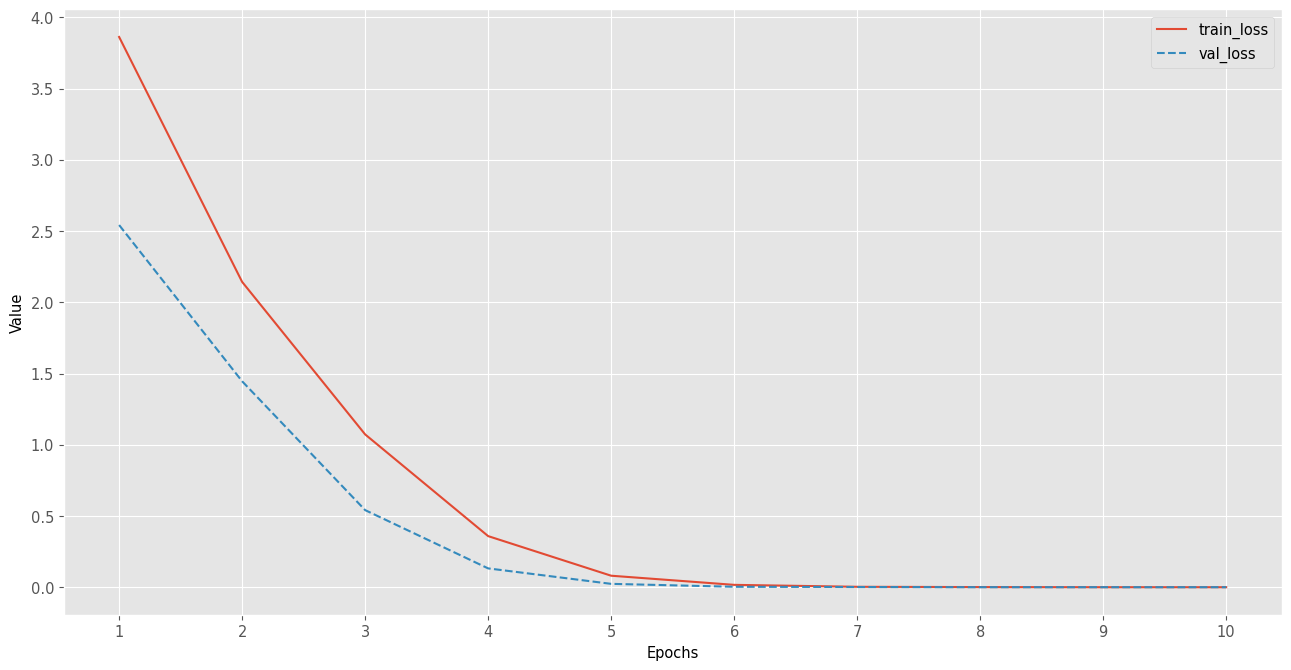

/opt/conda/lib/python3.10/site-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


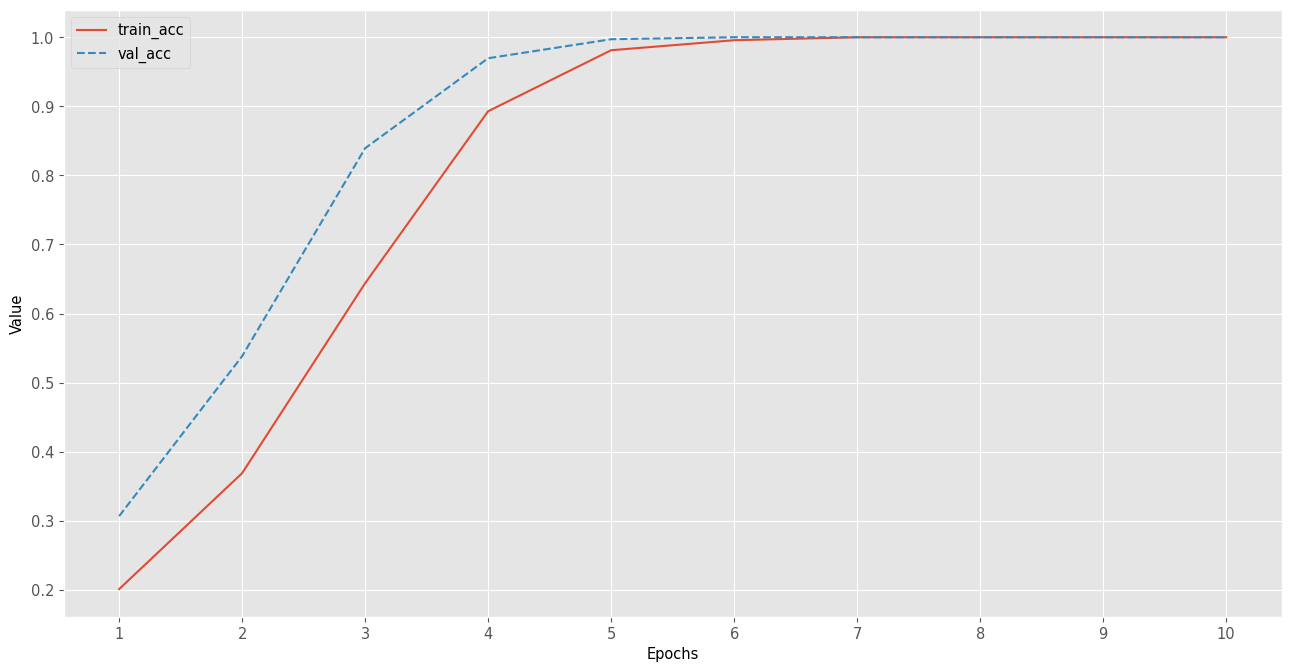

In [18]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  # Get prediction form model on validation data.
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

In [21]:
from huggingface_hub import login
login()

In [22]:
model.push_to_hub("JayalekshmiGopakumar/falconb_qlora_finetuned40b")
tokenizer.push_to_hub("JayalekshmiGopakumar/falconb_qlora_finetuned40b")

adapter_model.bin:   0%|          | 0.00/223M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/JayalekshmiGopakumar/falconb_qlora_finetuned40b/commit/bfdc28afaa1ae085dedf16de9b082a3d006146ed', commit_message='Upload tokenizer', commit_description='', oid='bfdc28afaa1ae085dedf16de9b082a3d006146ed', pr_url=None, pr_revision=None, pr_num=None)

In [28]:
text="The human body is made up of a complex community of trillions of cells of diverse shapes and sizes, all working together to keep you alive. The smallest of these cells, like platelets and red blood cells, are dwarfed by massive muscle cells. When it comes to size, it’s like comparing a shrew to a blue whale."
inputs = tokenizer(text, return_tensors="pt")
del inputs['token_type_ids']
with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()
model.config.id2label[predicted_class_id]

/opt/conda/lib/python3.10/site-packages/peft/tuners/lora.py:225: DeprecationWarning: invalid escape sequence '\.'
  layer_index = re.match(f".*.{pattern}\.(\d+)\.*", key)


OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 79.15 GiB total capacity; 22.47 GiB already allocated; 377.69 MiB free; 23.30 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## **Evaluate**

When dealing with classification is useful to look at precision recall and F1 score.

A good gauge to have when evaluating a model is the confusion matrix.

  0%|          | 0/22 [00:00<?, ?it/s]

                      precision    recall  f1-score   support

   financial_reports       1.00      1.00      1.00       208
             manuals       1.00      1.00      1.00       139
  government_tenders       1.00      1.00      1.00        39
laws_and_regulations       1.00      1.00      1.00       114
 scientific_articles       1.00      1.00      1.00       129
             patents       1.00      1.00      1.00        62

            accuracy                           1.00       691
           macro avg       1.00      1.00      1.00       691
        weighted avg       1.00      1.00      1.00       691

Normalized confusion matrix


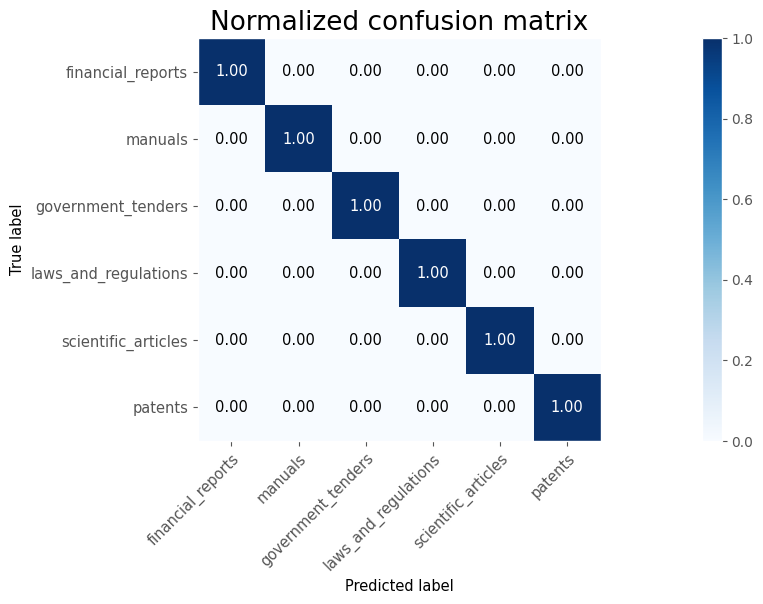

In [19]:
# Get prediction form model on validation data. This is where you should use
# your test data.
true_labels, predictions_labels, avg_epoch_loss = validation(valid_dataloader, device)

# Create the evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
# Show the evaluation report.
print(evaluation_report)

# Plot confusion matrix.
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels,
                      classes=list(labels_ids.keys()), normalize=True,
                      magnify=0.1,
                      );

In [ ]:

"""from transformers import AutoModelForSequenceClassification,AutoTokenizer,BertConfig
from torch import nn
from typing import Any, List, Optional, Union
import os
import torch
class BARTDecoder(nn.Module):


    def __init__(
        self,max_position_embeddings,decoder_layer,name_or_path
    ):
        super().__init__()
        #decoder_layer: int, max_position_embeddings: int, name_or_path: Union[str, bytes, os.PathLike] = None
        self.decoder_layer = decoder_layer
        self.max_position_embeddings = max_position_embeddings
        self.tokenizer=AutoTokenizer.from_pretrained('bert-base-uncased')
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased',
            config=BertConfig(
                num_hidden_layers=decoder_layer,
                vocab_size=len(self.tokenizer),
                max_position_embeddings =max_position_embeddings
          
            ),ignore_mismatched_sizes=True
        )
        self.model.forward = self.forward  #  to get cross attentions and utilize `generate` function

        self.model.config.is_encoder_decoder = True  # to get cross-attention
        self.add_special_tokens(["<sep/>"])  # <sep/> is used for representing a list in a JSON
        #self.model.model.decoder.embed_tokens.padding_idx = self.tokenizer.pad_token_id
        self.model.prepare_inputs_for_generation = self.prepare_inputs_for_inference
        print(self.max_position_embeddings)
        # weight init with asian-bart
        if not name_or_path:
            bart_state_dict = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased').state_dict()
            new_bart_state_dict = self.model.state_dict()
            self.model.load_state_dict(new_bart_state_dict)

    def add_special_tokens(self, list_of_tokens: List[str]):
        """
        Add special tokens to tokenizer and resize the token embeddings
        """
        newly_added_num = self.tokenizer.add_special_tokens({"additional_special_tokens": sorted(set(list_of_tokens))})
        if newly_added_num > 0:
            self.model.resize_token_embeddings(len(self.tokenizer))

    def prepare_inputs_for_inference(self, input_ids: torch.Tensor, encoder_outputs: torch.Tensor, past_key_values=None, past=None, use_cache: bool = None, attention_mask: torch.Tensor = None):

        # for compatibility with transformers==4.11.x
        if past is not None:
            past_key_values = past
        attention_mask = input_ids.ne(self.tokenizer.pad_token_id).long()
        if past_key_values is not None:
            input_ids = input_ids[:, -1:]
        output = {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "past_key_values": past_key_values,
            "use_cache": use_cache,
            "encoder_hidden_states": encoder_outputs.last_hidden_state,
        }
        return output

    def forward(
        self,
        input_ids,
        attention_mask: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        past_key_values: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        use_cache: bool = None,
        output_attentions: Optional[torch.Tensor] = None,
        output_hidden_states: Optional[torch.Tensor] = None,
        return_dict: bool = None,
    ):
    
        output_attentions = output_attentions if output_attentions is not None else self.model.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.model.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.model.config.use_return_dict
        print(input_ids.shape)
        outputs,_= self.model.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=encoder_hidden_states,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        logits = self.model.lm_head(outputs[0])

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(logits.view(-1, self.model.config.vocab_size), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[1:]
            return (loss,) + output if loss is not None else output

        return ModelOutput(
            loss=loss,
            logits=logits,
            past_key_values=outputs.past_key_values,
            hidden_states=outputs.hidden_states,
            decoder_attentions=outputs.attentions,
            cross_attentions=outputs.cross_attentions,
        )

    @staticmethod
    def resize_bart_abs_pos_emb(weight: torch.Tensor, max_length: int) -> torch.Tensor:
        """
        Resize position embeddings
        Truncate if sequence length of Bart backbone is greater than given max_length,
        else interpolate to max_length
        """
        if weight.shape[0] > max_length:
            weight = weight[:max_length, ...]
        else:
            weight = (
                F.interpolate(
                    weight.permute(1, 0).unsqueeze(0),
                    size=max_length,
                    mode="linear",
                    align_corners=False,
                )
                .squeeze(0)
                .permute(1, 0)
            )
        return weight







"""

from peft import PeftModelForSequenceClassification
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name="JayalekshmiGopakumar/falcon_qlora_finetuned"
tokenizer = AutoTokenizer.from_pretrained("JayalekshmiGopakumar/falcon_qlora_finetuned")
m=PeftModelForSequenceClassification.from_pretrained(AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path='tiiuae/falcon-7b',trust_remote_code=True),model_id="JayalekshmiGopakumar/falcon_qlora_finetuned")



text="The Financial Statement Data Sets below provide numeric information from the face financials of all financial statements.This data is extracted from exhibits to corporate financial reports filed with the Commission using eXtensible Business Reporting Language (XBRL).  As compared to the more extensive Financial Statement and Notes Data Sets, which provide the numeric and narrative disclosures from all financial statements and their notes, the Financial Statement Data Sets are more compact."
inputs = tokenizer(text, return_tensors="pt")

with torch.no_grad():
    logits = m(**inputs).logits

predicted_class_id = logits.argmax().item()

In [12]:
#!pip install git+https://github.com/gmihaila/ml_things.git
#!pip install einops

  Using cached einops-0.6.1-py3-none-any.whl (42 kB)


In [27]:
torch.cuda.empty_cache()